# Подготовка данных для модели

In [ ]:
!git clone https://github.com/Nazar1997/Sparse_vector

In [ ]:
import pandas as pd
import numpy as np
import scipy
from tqdm import trange
from tqdm.notebook import tqdm
import sys
import os
import seaborn as sns
from matplotlib import pyplot as plt
from joblib import Parallel, delayed, dump, load
from matplotlib import pyplot as plt
from Sparse_vector.sparse_vector import SparseVector

In [ ]:
!tar -xvf "neural.tar.gz"

# Обработка данных

In [ ]:
chroms = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
all_features = [i[:-4] for i in os.listdir('./omicDC_results') if i.endswith('.pkl')]

In [ ]:
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs']
feature_names = [i for i in all_features if (i.split('_')[0] in groups)]

def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'../data/hg19_dna/') if f"{chrom}_" in i])
    return ''.join([load(f"../data/hg19_dna/{file}") for file in files])

In [ ]:
feature_names = feature_names[:60]

In [ ]:
%%time
# load all the data
DNA_features = {feture: load(f'./omicDC_results/{feture}.pkl')
                for feture in tqdm(feature_names)}

  0%|          | 0/60 [00:00<?, ?it/s]

CPU times: user 869 ms, sys: 26.8 ms, total: 896 ms
Wall time: 921 ms


In [ ]:
DNA_features

In [ ]:
breakpoints = pd.read_csv(f'./filtered_brain_data.bed', sep='\t', header=None)
breakpoints.columns = ['chr', 'chr_bkpt_beg', 'chr_bkpt_end']
breakpoints

In [ ]:
!wget https://raw.githubusercontent.com/xen234/cancer-genome-bp-backup/main/data/raw/brain_all_data.csv

In [ ]:
breakpoints = pd.read_csv('brain_all_data.csv')
cols = ['chr', 'chr_bkpt_beg', 'chr_bkpt_end']
breakpoints = breakpoints[cols]
breakpoints['chr'] = breakpoints['chr'].apply(lambda x: 'chr' + x)


breakpoints

,chr,chr_bkpt_beg,chr_bkpt_end
0,chr7,138539032,138539032
1,chr6,163987396,163987396
2,chr7,138537675,138537675
3,chr7,138548514,138548514
4,chr7,138541988,138541988
...,...,...,...
1559,chr18,44778253,44778253
1560,chr5,14314337,14314337
1561,chrX,91194619,91194619
1562,chr18,6953106,6953106


In [ ]:
df = pd.DataFrame(DNA_features)
df

In [ ]:
chroms = ['chr1', 'chr10', 'chr11', 'chr11_gl000202_random', 'chr12', 'chr13',
       'chr14', 'chr15', 'chr16', 'chr17', 'chr17_ctg5_hap1',
       'chr17_gl000203_random', 'chr17_gl000204_random',
       'chr17_gl000205_random', 'chr17_gl000206_random', 'chr18',
       'chr18_gl000207_random', 'chr19', 'chr19_gl000208_random',
       'chr19_gl000209_random', 'chr1_gl000191_random', 'chr1_gl000192_random',
       'chr2', 'chr20', 'chr21', 'chr21_gl000210_random', 'chr22', 'chr3',
       'chr4', 'chr4_ctg9_hap1', 'chr4_gl000193_random',
       'chr4_gl000194_random', 'chr5', 'chr6', 'chr6_apd_hap1',
       'chr6_cox_hap2', 'chr6_dbb_hap3', 'chr6_mann_hap4', 'chr6_mcf_hap5',
       'chr6_qbl_hap6', 'chr6_ssto_hap7', 'chr7', 'chr7_gl000195_random',
       'chr8', 'chr8_gl000196_random', 'chr8_gl000197_random', 'chr9',
       'chr9_gl000198_random', 'chr9_gl000199_random', 'chr9_gl000200_random',
       'chr9_gl000201_random', 'chrM', 'chrUn_gl000211', 'chrUn_gl000212',
       'chrUn_gl000213', 'chrUn_gl000214', 'chrUn_gl000215', 'chrUn_gl000216',
       'chrUn_gl000217', 'chrUn_gl000218', 'chrUn_gl000219', 'chrUn_gl000220',
       'chrUn_gl000221', 'chrUn_gl000222', 'chrUn_gl000223', 'chrUn_gl000224',
       'chrUn_gl000225', 'chrUn_gl000226', 'chrUn_gl000227', 'chrUn_gl000228',
       'chrUn_gl000229', 'chrUn_gl000230', 'chrUn_gl000231', 'chrUn_gl000232',
       'chrUn_gl000233', 'chrUn_gl000234', 'chrUn_gl000235', 'chrUn_gl000236',
       'chrUn_gl000237', 'chrUn_gl000238', 'chrUn_gl000239', 'chrUn_gl000240',
       'chrUn_gl000241', 'chrUn_gl000242', 'chrUn_gl000243', 'chrUn_gl000244',
       'chrUn_gl000245', 'chrUn_gl000246', 'chrUn_gl000247', 'chrUn_gl000248',
       'chrUn_gl000249', 'chrX', 'chrY']
chroms_todrop = []
for chr in chroms:
  if len(chr) > 5:
    chroms_todrop.append(chr)

for inner_dict in DNA_features.values():
  for chr in chroms_todrop:
    inner_dict.pop(chr, None)


In [ ]:
import math

columns = ['chr', 'chr_bkpt', 'window', 'mark', 'peak', 'is_bkpt']
features = pd.DataFrame(columns=columns)
window_fixed = 50

for i in range(window_fixed):
    column_name = f'col_{i+1}'
    features[column_name] = i

for index, row in breakpoints.iterrows():
  for key1 in DNA_features.keys():
    row_data = {
        'chr': row['chr'],
        'chr_bkpt': row['chr_bkpt_beg'],
        'window': math.ceil(row['chr_bkpt_beg'] / window_fixed),
        'mark': key1,
        'peak': DNA_features[key1][row['chr']][row['chr_bkpt_beg']],
        'is_bkpt': 1
    }
    for i in range (window_fixed):
        coord = row_data['window'] * (window_fixed - 1)
        row_data[f'col_{i+1}'] = DNA_features[key1][row['chr']][coord + i]
    
    row_df = pd.DataFrame(row_data, index=[0])
    features = pd.concat([features, row_df], ignore_index=True)

    

features

,chr,chr_bkpt,window,mark,peak,is_bkpt,col_1,col_2,col_3,col_4,...,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50
0,chr7,138539032,2770781,TFs_and_others_ZFP30,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,chr7,138539032,2770781,TFs_and_others_TSHZ2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,chr7,138539032,2770781,TFs_and_others_CDK9,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,chr7,138539032,2770781,TFs_and_others_KDM1A,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,chr7,138539032,2770781,TFs_and_others_OLIG2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93835,chr19,54992899,1099858,TFs_and_others_EZH2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93836,chr19,54992899,1099858,TFs_and_others_GTF3C5,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93837,chr19,54992899,1099858,Histone_H3K9me1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93838,chr19,54992899,1099858,TFs_and_others_STAG2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import random

def generate_random_coordinate(min_value, max_value):
    chroms = ['chr1', 'chr3', 'chr10', 'chr5', 'chr12', 'chr22', 'chr9', 'chr11',
       'chr17', 'chr4', 'chr2', 'chr19', 'chr20', 'chr14', 'chr7',
       'chr16', 'chr15', 'chrX', 'chr13', 'chr6', 'chr21', 'chr8',
       'chr18']
    x = random.randint(min_value, max_value)
    chr_num = random.randint(0, 22)
    return (chroms[chr_num], x)

features_false = pd.DataFrame(columns=features.columns)
min_val, max_val = breakpoints.chr_bkpt_beg.min(),  breakpoints.chr_bkpt_beg.max()
s = breakpoints.shape[0]
blacklist_tuples = set()
unique_rows = features.drop_duplicates(subset='chr_bkpt')

for index, row in unique_rows.iterrows():
  blacklist_tuples.add((row['chr'], row['chr_bkpt']))

min_val, max_val

(107973, 235256236)

In [ ]:
for i in range(s):
  while True:
    random_tuple = generate_random_coordinate(min_val - 1000, max_val + 1000)
    if random_tuple not in blacklist_tuples:
      break
  

  blacklist_tuples.add(random_tuple)
  print('PASSED! ', i, DNA_features['Histone_H3K9ac'][random_tuple[0]][random_tuple[1]], sep=' ')
  
  for key1 in DNA_features.keys():
    row_data = {
        'chr': random_tuple[0],
        'chr_bkpt': random_tuple[1],
        'window': math.ceil(random_tuple[1] / window_fixed),
        'mark': key1,
        'peak': DNA_features[key1][random_tuple[0]][random_tuple[1]],
        'is_bkpt': 0
    }

    for i in range (window_fixed):
        coord = row_data['window'] * (window_fixed - 1)
        row_data[f'col_{i+1}'] = DNA_features[key1][random_tuple[0]][coord + i]

    row_df = pd.DataFrame(row_data, index=[0])
    features_false = pd.concat([features_false, row_df], ignore_index=True)

features_false
  

In [ ]:
features_false

,chr,chr_bkpt,window,mark,peak,is_bkpt,col_1,col_2,col_3,col_4,...,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50
0,chr11,46459567,929192,TFs_and_others_ZFP30,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,chr11,46459567,929192,TFs_and_others_TSHZ2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,chr11,46459567,929192,TFs_and_others_CDK9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,chr11,46459567,929192,TFs_and_others_KDM1A,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,chr11,46459567,929192,TFs_and_others_OLIG2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93835,chr19,213349823,4266997,TFs_and_others_EZH2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93836,chr19,213349823,4266997,TFs_and_others_GTF3C5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93837,chr19,213349823,4266997,Histone_H3K9me1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93838,chr19,213349823,4266997,TFs_and_others_STAG2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:

merged_df = pd.concat([features, features_false], ignore_index=True)
merged_df

,chr,chr_bkpt,window,mark,peak,is_bkpt,col_1,col_2,col_3,col_4,...,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50
0,chr7,138539032,2770781,TFs_and_others_ZFP30,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,chr7,138539032,2770781,TFs_and_others_TSHZ2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,chr7,138539032,2770781,TFs_and_others_CDK9,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,chr7,138539032,2770781,TFs_and_others_KDM1A,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,chr7,138539032,2770781,TFs_and_others_OLIG2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187675,chr19,213349823,4266997,TFs_and_others_EZH2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
187676,chr19,213349823,4266997,TFs_and_others_GTF3C5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
187677,chr19,213349823,4266997,Histone_H3K9me1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
187678,chr19,213349823,4266997,TFs_and_others_STAG2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
merged_df['is_bkpt'].value_counts()

1    93840
0    93840
Name: is_bkpt, dtype: int64

In [ ]:
if features['col_1'].isna().any():
    print("NaN values exist in the column")
else:
    print("No NaN values in the column")

if features['col_1'].isnull().any():
    print("NaN values exist in the column")
else:
    print("No NaN values in the column")

features

No NaN values in the column
No NaN values in the column


,chr,chr_bkpt,window,mark,is_bkpt,col_1,col_2,col_3,col_4,col_5,...,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50
0,chr7,138539032,2770781,TFs_and_others_ZFP30,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,chr7,138539032,2770781,TFs_and_others_TSHZ2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,chr7,138539032,2770781,TFs_and_others_CDK9,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,chr7,138539032,2770781,TFs_and_others_KDM1A,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,chr7,138539032,2770781,TFs_and_others_OLIG2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78195,chr19,54992899,1099858,Histone_H3S10ph,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78196,chr19,54992899,1099858,TFs_and_others_PBX3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78197,chr19,54992899,1099858,TFs_and_others_PARK7,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78198,chr19,54992899,1099858,TFs_and_others_MGMT,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
merged_df.to_csv('brain.peak.intervals.csv', index=False)

# Модель

In [ ]:
import torch
from torch.utils import data
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold

In [ ]:
merged_df = pd.read_csv('brain.peak.intervals.csv')

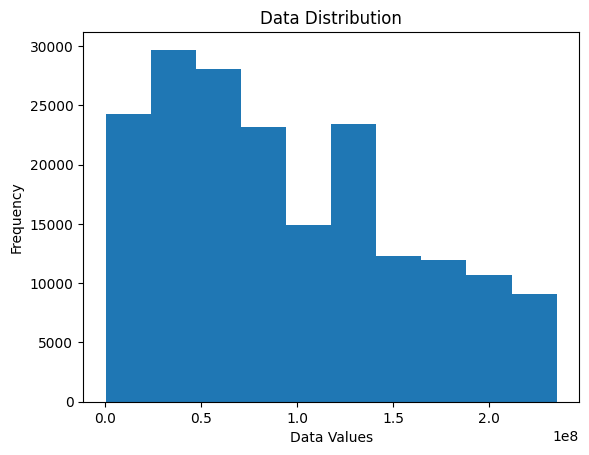

In [ ]:
import matplotlib.pyplot as plt

plt.hist(merged_df['chr_bkpt'], bins=10)
plt.xlabel('Data Values')
plt.ylabel('Frequency')
plt.title('Data Distribution')
plt.show()

In [ ]:
features

,chr,chr_bkpt,window,mark,peak,is_bkpt,col_1,col_2,col_3,col_4,...,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50
0,chr7,138539032,2770781,TFs_and_others_ZFP30,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,chr7,138539032,2770781,TFs_and_others_TSHZ2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,chr7,138539032,2770781,TFs_and_others_CDK9,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,chr7,138539032,2770781,TFs_and_others_KDM1A,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,chr7,138539032,2770781,TFs_and_others_OLIG2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93835,chr19,54992899,1099858,TFs_and_others_EZH2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93836,chr19,54992899,1099858,TFs_and_others_GTF3C5,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93837,chr19,54992899,1099858,Histone_H3K9me1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93838,chr19,54992899,1099858,TFs_and_others_STAG2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
features = merged_df.copy()
features

,chr,chr_bkpt,window,mark,peak,is_bkpt,col_1,col_2,col_3,col_4,...,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50
0,chr7,138539032,2770781,TFs_and_others_ZFP30,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,chr7,138539032,2770781,TFs_and_others_TSHZ2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,chr7,138539032,2770781,TFs_and_others_CDK9,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,chr7,138539032,2770781,TFs_and_others_KDM1A,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,chr7,138539032,2770781,TFs_and_others_OLIG2,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187675,chr19,213349823,4266997,TFs_and_others_EZH2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
187676,chr19,213349823,4266997,TFs_and_others_GTF3C5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
187677,chr19,213349823,4266997,Histone_H3K9me1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
187678,chr19,213349823,4266997,TFs_and_others_STAG2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
stat_functions = [np.mean, np.median, np.std, np.min, np.max]

for func in stat_functions:
    features[f'peak_{func.__name__}'] = features.iloc[:, 6:57].apply(func, axis=1)

In [ ]:
features['chr'] = features['chr'] + features['mark']
features.drop('mark', axis=1, inplace=True)  

In [ ]:
features['chr_bkpt'] = features['chr_bkpt'] / features['window']

In [ ]:
for i in range (50):
  features[f'col_{i + 1}'] = features[f'col_{i + 1}'] / features['window']

In [ ]:
from torch import nn
import torch
from torch.utils import data
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


X = features.drop(['is_bkpt', 'window', 'chr_bkpt'], axis=1)
y = features['is_bkpt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=42, shuffle=True)


label = LabelEncoder()
label.fit(X['chr'])
str_columns = ['chr']
X_train[str_columns] = X_train[str_columns].apply(lambda x: label.fit_transform(x))
X_test[str_columns] = X_test[str_columns].apply(lambda x: label.fit_transform(x))

print(features.columns)
scaler = StandardScaler()
cols = ['peak', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6',
        'col_7', 'col_8', 'col_9', 'col_10',
        'col_11', 'col_12', 'col_13', 'col_14', 'col_15', 'col_16', 'col_17',
        'col_18', 'col_19', 'col_20', 'col_21', 'col_22', 'col_23', 'col_24',
        'col_25', 'col_26', 'col_27', 'col_28', 'col_29', 'col_30', 'col_31',
        'col_32', 'col_33', 'col_34', 'col_35', 'col_36', 'col_37', 'col_38',
        'col_39', 'col_40', 'col_41', 'col_42', 'col_43', 'col_44', 'col_45',
        'col_46', 'col_47', 'col_48', 'col_49', 'col_50', 'peak_mean',
        'peak_median', 'peak_std', 'peak_amin', 'peak_amax']

X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])


params = {'batch_size':20,
          'num_workers':2,
          'shuffle':True}

X_train_array = X_train.values.astype(np.float32)
y_train_array = y_train.values.astype(np.float32)
X_val_array = X_test.values.astype(np.float32)
y_val_array = y_test.values.astype(np.float32)


train_dset = torch.utils.data.TensorDataset(torch.from_numpy(X_train_array).float(),
                                            torch.from_numpy(y_train_array).reshape(-1, 1).float())

val_dset = torch.utils.data.TensorDataset(torch.from_numpy(X_val_array).float(),
                                           torch.from_numpy(y_val_array).reshape(-1, 1).float())


train_loader = torch.utils.data.DataLoader(train_dset, **params)
val_loader = torch.utils.data.DataLoader(val_dset, **params)

Index(['chr', 'chr_bkpt', 'window', 'peak', 'is_bkpt', 'col_1', 'col_2',
       'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'col_8', 'col_9', 'col_10',
       'col_11', 'col_12', 'col_13', 'col_14', 'col_15', 'col_16', 'col_17',
       'col_18', 'col_19', 'col_20', 'col_21', 'col_22', 'col_23', 'col_24',
       'col_25', 'col_26', 'col_27', 'col_28', 'col_29', 'col_30', 'col_31',
       'col_32', 'col_33', 'col_34', 'col_35', 'col_36', 'col_37', 'col_38',
       'col_39', 'col_40', 'col_41', 'col_42', 'col_43', 'col_44', 'col_45',
       'col_46', 'col_47', 'col_48', 'col_49', 'col_50', 'peak_mean',
       'peak_median', 'peak_std', 'peak_amin', 'peak_amax'],
      dtype='object')


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train_array, y_train_array)

y_pred = model.predict(X_val_array)

accuracy = accuracy_score(y_val_array, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7000852514919012


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression


model = LinearRegression()
model.fit(X_train, y_train)


coefficients = pd.Series(model.coef_, index=X_train.columns)
most_weighted_column = coefficients.idxmax()
print("Most weighted column:", most_weighted_column)

Most weighted column: col_37


In [ ]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV


param_grid = {'learning_rate': [0.001, 0.01, 0.1, 0.2]}

model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=5)
grid_search.fit(X_train_array, y_train_array)

best_learning_rate = grid_search.best_params_['learning_rate']
best_score = grid_search.best_score_

model.set_params(learning_rate=best_learning_rate)

model.fit(X_train_array, y_train_array)
y_pred_proba = model.predict_proba(X_val_array)[:, 1]

auc_roc = roc_auc_score(y_val_array, y_pred_proba)
print(f"Optimized AUC-ROC: {auc_roc}")

In [ ]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score


model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


model.fit(X_train_array, y_train_array)

y_pred_proba = model.predict_proba(X_val_array)[:, 1]

auc_roc = roc_auc_score(y_val_array, y_pred_proba)
print(f"AUC-ROC: {auc_roc}")

AUC-ROC: 0.7635760302675502


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data


class TwoClassClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoClassClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


input_size = X_train.shape[1] 
hidden_size = 500
output_size = 1


model = TwoClassClassifier(input_size, hidden_size, output_size)


criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

    model.eval()

    true_labels = []
    predicted_probs = []

    for inputs, labels in val_loader:
        outputs = model(inputs)
        probs = torch.sigmoid(outputs)

        labels_np = labels.numpy()
        probs_np = probs.detach().numpy()
        
        true_labels.append(labels_np)
        predicted_probs.append(probs_np)
        
    true_labels = np.concatenate(true_labels)
    predicted_probs = np.concatenate(predicted_probs)

    auc_roc = roc_auc_score(true_labels, predicted_probs)
    print(f"AUC-ROC: {auc_roc}")

AUC-ROC: 0.5634254688105274
AUC-ROC: 0.5836272256780692
AUC-ROC: 0.6246072780644931
AUC-ROC: 0.5913756176281625
AUC-ROC: 0.5948424516726517
AUC-ROC: 0.6112201551642563
AUC-ROC: 0.6007732178132011
AUC-ROC: 0.5997241104918931
AUC-ROC: 0.6050507584330296
AUC-ROC: 0.6017923378949785
